# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">FILL IN TIME</span>
* 2. Part B: <span style="color:red;">FILL IN TIME</span>
* 3. Part C: <span style="color:red;">FILL IN TIME</span>
* 4. Tests: <span style="color:red;">FILL IN TIME</span>
* 5. Challenge 1: <span style="color:red;">FILL IN TIME</span>
* 6. Challenge 2: <span style="color:red;">FILL IN TIME</span>
* 7. Write-up: <span style="color:red;">FILL IN TIME</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from math import degrees
plt.rcParams['figure.figsize'] = [20,15]

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

In [63]:
def plotImage(image, subplot, title):
    plt.rcParams['figure.figsize'] = [10,5]
    plt.rcParams['axes.titlesize'] = '16'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.subplot(subplot)
    plt.title(title)
    plt.imshow(image, cmap='gray')

def preprocessImage(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = np.where(image > 140, 255, 0)
    return image

#checks if x:y is close enough to r1:r2
def isRatio(x, y, r1, r2):
    errorCap = 0.3
    
    if y == 0:
        return False
    
    xOverY = x/y
    
    ratio = r1/r2
    
    difference = abs(xOverY - ratio)
    
    if difference <= errorCap:
        return True
    else:
        return False
    

def findCandidatePositionMarkers(image, rstart=0, cstart=0, rinc=1, cinc=1):
    #change image to 3d pixels
    accumulator = np.zeros(image.shape, dtype=int)

    BLACK = 0
    WHITE = 255
    
    blackLeft = 0
    whiteLeft = 0
    blackMid = 0
    whiteRight = 0
    blackRight = 0
    
    currentColor = -1
    
    tempWhite = 0
    tempBlack = 0
    
    for r in range(image.shape[0]):
        for c in range(image.shape[1] + 1):
            #if we're at the end of an iteration and the last pixel was black, do a check
            if c == image.shape[1]:
                if currentColor == BLACK:
                    blackLeft = blackMid
                    whiteLeft = whiteRight
                    blackMid = blackRight
                    whiteRight = tempWhite
                    blackRight = tempBlack
                    tempWhite = 0
                    tempBlack = 0

                    #see if it's a 1:1:3:1:1 ratio
                    if isRatio(blackLeft, whiteLeft, 1,1):
                        if isRatio(whiteLeft, blackMid, 1,3):
                            if isRatio(blackMid, whiteRight, 3,1):
                                if isRatio(whiteRight, blackRight, 1,1):
                                    #it passed all the tests, save the point from the middle black
                                    middle = int(c - blackRight - whiteRight - (blackMid/2))
                                    accumulator[r][middle] += 5
                    continue
                continue
                
            value = image[r][c]
            
            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue
            
            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue
            
            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE
                
                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middle = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[r][middle] += 5
                
                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue
            
            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
        
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    return accumulator


def find2(image, accumulator):
    #this time do it vertically
    BLACK = 0
    WHITE = 255
    
    blackLeft = 0
    whiteLeft = 0
    blackMid = 0
    whiteRight = 0
    blackRight = 0
    
    currentColor = -1
    
    tempWhite = 0
    tempBlack = 0
    
    for c in range(image.shape[1]):
        for r in range(image.shape[0] + 1):
            #if we're at the end of an iteration and the last pixel was black, do a check
            if r == image.shape[0]:
                if currentColor == BLACK:
                    blackLeft = blackMid
                    whiteLeft = whiteRight
                    blackMid = blackRight
                    whiteRight = tempWhite
                    blackRight = tempBlack
                    tempWhite = 0
                    tempBlack = 0

                    #see if it's a 1:1:3:1:1 ratio
                    if isRatio(blackLeft, whiteLeft, 1,1):
                        if isRatio(whiteLeft, blackMid, 1,3):
                            if isRatio(blackMid, whiteRight, 3,1):
                                if isRatio(whiteRight, blackRight, 1,1):
                                    #it passed all the tests, save the point from the middle black
                                    middle = int(r - blackRight - whiteRight - (blackMid/2))
                                    accumulator[middle][c] += 5
                    continue
                continue
                
            value = image[r][c]
            
            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue
            
            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue
            
            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE
                
                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middle = int(r - blackRight - whiteRight - (blackMid/2))
                                accumulator[middle][c] += 5
                
                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue
            
            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
        
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    return accumulator


#this time do it from bottom left to diagonal (inclusive)
def find3(image, accumulator):    
    BLACK = 0
    WHITE = 255

    #for start positions (so just going up the left hand side)
    for startr in range(image.shape[0]-1, -1, -1):
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0

        currentColor = -1

        tempWhite = 0
        tempBlack = 0
        
        #c always starts as 0
        r = startr - 1
        c = 0 - 1
        
        #actually go diagonally
        while True:
            #increment row and column by 1 to go diagonally
            r += 1
            c += 1
            if r >= image.shape[0] or c >= image.shape[1]:
                break
#             print(r,c, image.shape)
            value = image[r][c]

            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue

            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue

            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE

                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middler = int(r - blackRight - whiteRight - (blackMid/2))
                                middlec = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[middler][middlec] += 5

                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue

            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
                
            
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    return accumulator

#from diagonal (exclusive) to top right
def find4(image, accumulator):
    BLACK = 0
    WHITE = 255
    
    #for start positions (so just going along the top)
    for startc in range(1, image.shape[1], 1):
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0

        currentColor = -1

        tempWhite = 0
        tempBlack = 0
        
        #r always starts as 0
        r = 0 - 1
        c = startc - 1
        
        #actually go diagonally
        while True:
            #increment row and column by 1 to go diagonally
            r += 1
            c += 1
            if r >= image.shape[0] or c >= image.shape[1]:
                break
#             print(r,c, image.shape)
            value = image[r][c]

            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue

            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue

            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE

                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middler = int(r - blackRight - whiteRight - (blackMid/2))
                                middlec = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[middler][middlec] += 5

                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue

            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
                
            
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    return accumulator

#from top left to diagonal (inclusive)
def find5(image, accumulator):
    BLACK = 0
    WHITE = 255
    
    #for start positions (so just going down the left hand side)
    for startr in range(0, image.shape[0], 1):
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0

        currentColor = -1

        tempWhite = 0
        tempBlack = 0
        
        #c always starts as 0
        r = startr - 1
        c = 0 - 1
        
        #actually go diagonally
        while True:
            #decrement row and increment column by 1 to go diagonally
            r -= 1
            c += 1
            if r < 0 or c >= image.shape[1]:
                break
            value = image[r][c]

            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue

            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue

            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE

                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middler = int(r + blackRight + whiteRight + (blackMid/2))
                                middlec = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[middler][middlec] += 5

                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue

            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
                
            
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    
    return accumulator

#from diagonal (exclusive) to bottom right
def find6(image, accumulator):
    BLACK = 0
    WHITE = 255
    
    #for start positions (so just going along the bottom)
    for startc in range(1, image.shape[1], 1):
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0

        currentColor = -1

        tempWhite = 0
        tempBlack = 0
        
        #r always starts as image.shape[0]-1
        r = (image.shape[0] - 1) - 1
        c = startc - 1
        
        #actually go diagonally
        while True:
            #decrement row and increment column by 1 to go diagonally
            r -= 1
            c += 1
            if r < 0 or c >= image.shape[1]:
                break
            value = image[r][c]

            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue

            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue

            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE

                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middler = int(r + blackRight + whiteRight + (blackMid/2))
                                middlec = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[middler][middlec] += 5

                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue

            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
                
            
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    
    return accumulator


#from bottom left to diagonal skewed (inclusive)
def find7(image, accumulator):
    BLACK = 0
    WHITE = 255

    #for start positions (so just going up the left hand side by 2)
    for startr in range(image.shape[0]-1, -1, -2):
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0

        currentColor = -1

        tempWhite = 0
        tempBlack = 0
        
        #c always starts as 0
        r = startr - 1
        c = 0 - 1
        
        #actually go diagonally
        while True:
            #increment row by 2 and column by 1 to go diagonally
            r += 2
            c += 1
            if r >= image.shape[0] or c >= image.shape[1]:
                break

            value = image[r][c]

            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue

            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue

            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE

                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middler = int(r - 2*blackRight - 2*whiteRight - 2*(blackMid/2))
                                middlec = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[middler][middlec] += 5

                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue

            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
                
            
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    
    return accumulator

    
#from diagonal skewed (exclusive) to top right
def find8(image, accumulator):
    BLACK = 0
    WHITE = 255
    
    #for start positions (so just going along the top)
    for startc in range(1, image.shape[1], 1):
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0

        currentColor = -1

        tempWhite = 0
        tempBlack = 0
        
        #r always starts as 0
        r = 0 - 1
        c = startc - 1
        
        #actually go diagonally
        while True:
            #increment row by 2 and column by 1 to go diagonally
            r += 2
            c += 1
            if r >= image.shape[0] or c >= image.shape[1]:
                break

            value = image[r][c]

            if value == WHITE and currentColor == WHITE:
                tempWhite += 1
                continue

            if value == BLACK and currentColor == BLACK:
                tempBlack += 1
                continue

            #if we just switched to seeing a white region, shift down the counters
            if value == WHITE and currentColor != WHITE:
                currentColor = WHITE

                blackLeft = blackMid
                whiteLeft = whiteRight
                blackMid = blackRight
                whiteRight = tempWhite
                blackRight = tempBlack
                tempWhite = 0
                tempBlack = 0

                #see if it's a 1:1:3:1:1 ratio
                if isRatio(blackLeft, whiteLeft, 1,1):
                    if isRatio(whiteLeft, blackMid, 1,3):
                        if isRatio(blackMid, whiteRight, 3,1):
                            if isRatio(whiteRight, blackRight, 1,1):
                                #it passed all the tests, save the point from the middle black
                                middler = int(r - 2*blackRight - 2*whiteRight - 2*(blackMid/2))
                                middlec = int(c - blackRight - whiteRight - (blackMid/2))
                                accumulator[middler][middlec] += 5

                #After shifting and running test, increment white count (because all this happened because we saw a white pixel)
                tempWhite += 1
                continue

            #if we just switched to seeing a black region, switch current color and increment black
            if value == BLACK and currentColor != BLACK:
                currentColor = BLACK
                tempBlack += 1
                
            
        #reset all counts because you're at the end of a row
        blackLeft = 0
        whiteLeft = 0
        blackMid = 0
        whiteRight = 0
        blackRight = 0
        tempWhite = 0
        tempBlack = 0
        currentColor = -1
    
    return accumulator

def nonMaxSuppress(accumulator):
    xs = []
    ys = []
    angleThreshold = 0.3
    
    sobelKernelX = np.array([[-1,0,1], [-2,0,2], [-1,0,1]]) 
    sobelKernelY = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    
    dx = convolve(accumulator, sobelKernelX)
    dy = convolve(accumulator, sobelKernelY)
    
    magnitude = np.sqrt(dx**2 + dy**2, dtype='float')
    angle = np.arctan2(dx, dy)
    
    size = 3
    offset = int((size - 1)/2)
    
    for r in range(angle.shape[0]):
        for c in range(angle.shape[1]):
            angle[r,c] = degrees(angle[r][r])
            
    maxTotal = accumulator.max()
    print(maxTotal)
    
    for y in range(offset, accumulator.shape[0] - offset):
        for x in range(offset, accumulator.shape[1] - offset):
            neighborhood = accumulator[y-offset:y+offset+1, x-offset:x+offset+1]
            if neighborhood[1,1] == maxTotal:
                pass
    

def findPoints(path):
    image = preprocessImage(path)
    accumulator = findCandidatePositionMarkers(image)
    accumulator = find2(image, accumulator)
    accumulator = find3(image, accumulator)
    accumulator = find4(image, accumulator)
    accumulator = find5(image, accumulator)
    accumulator = find6(image, accumulator)
    accumulator = find7(image, accumulator)
    accumulator = find8(image, accumulator)
    points = nonMaxSuppress(accumulator)
    plotImage(image, 121, "Points")
    plotImage(accumulator, 122, "Accumulator")

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

In [ ]:
# Your Code Here

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [ ]:
# Your Code Here

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [ ]:
from decoder import decode
output = decode(your_array)
print(output)

## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

## RUN ME

20


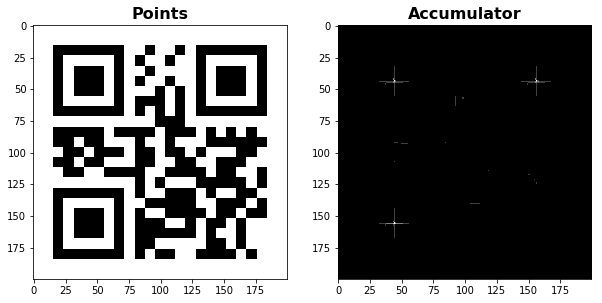

In [64]:
findPoints("QR_codes/test1.png")
plt.show()

15


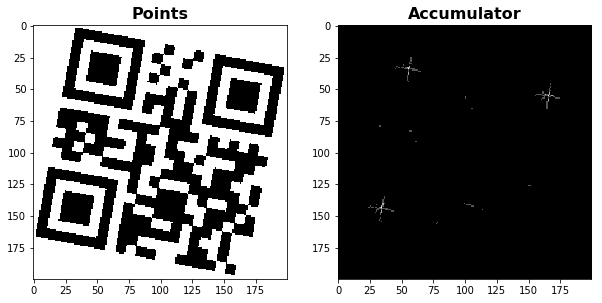

In [58]:
findPoints("QR_codes/test2.png")
plt.show()

20


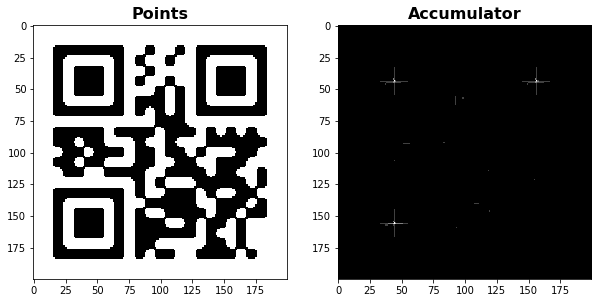

In [59]:
findPoints("QR_codes/test3.png")
plt.show()

20


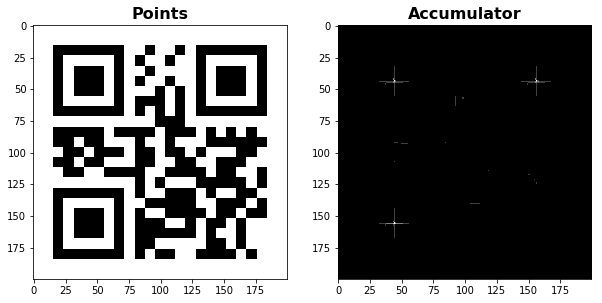

In [60]:
findPoints("QR_codes/test4.png")
plt.show()

20


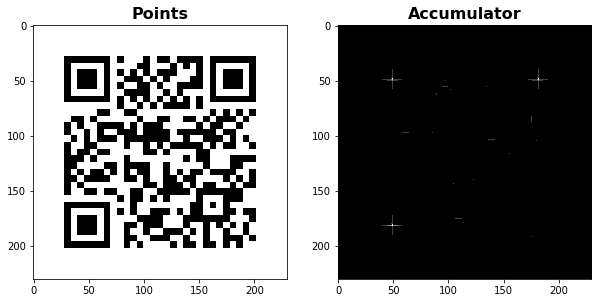

In [61]:
findPoints("QR_codes/test5.png")
plt.show()


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



In [ ]:
image = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge2.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge4.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()


image = cv2.imread("QR_codes/challenge5.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()



## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

Admittedly I only did part A, the non maximal suppression was the hardest for me